In [1]:
%matplotlib inline
import os
from os.path import join as pjoin
from tifffile import imread, imwrite, TiffFile
import numpy as np
import shutil
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import cv2
from tqdm import tqdm
import subprocess
from wf_utils import *
from wfield_utils import *
# from multi_load_images import *


In [2]:
### Set the file path

# path_0: including one-day recording files
# path_1: including every stimuli
path_0 = r"/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78"
path_1_ = os.listdir(path_0)
# 筛选出文件夹
path_1 = [folder for folder in path_1_ if os.path.isdir(pjoin(path_0, folder))]
path_all = []
for path in path_1:
    path_all.append(pjoin(path_0, path))

print('All the file path:\n'+'\n'.join(path_all))


All the file path:
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-invert
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-reverse
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/no-light
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/retinotopy


In [3]:
### re-organize files

for path in path_all:
    if not os.path.exists(pjoin(path, 'raw')):
        os.mkdir(pjoin(path, 'raw'))
    if not os.path.exists(pjoin(path, 'process/')):
        os.mkdir(pjoin(path, 'process/'))
        
for path in path_all:
    files = glob(pjoin(path, '202?????-??????*'))
    for file in files:
        shutil.move(file, pjoin(path, 'raw', os.path.basename(file)))
        print('moving',file)

print('Moving raw data folders all finished!')


moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline/20241111-214024-405Timestamp.csv
moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline/20241111-214024-470Timestamp.csv
moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline/20241111-214024.csv
moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline/20241111-214024-405
moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline/20241111-214024-470
moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline/20241111-214024-event
moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar/20241111-215129-405Timestamp.csv
moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar/20241111-215129-470Timestamp.csv
moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar/20241111-215129.csv
moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar/20241111-215129-405
moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar/20241111-215129-470
moving /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/movin

Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline
experiments:
['20241111-214024']


/home/lzx/.conda/envs/wfield/lib/python3.9/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20241111-214024-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


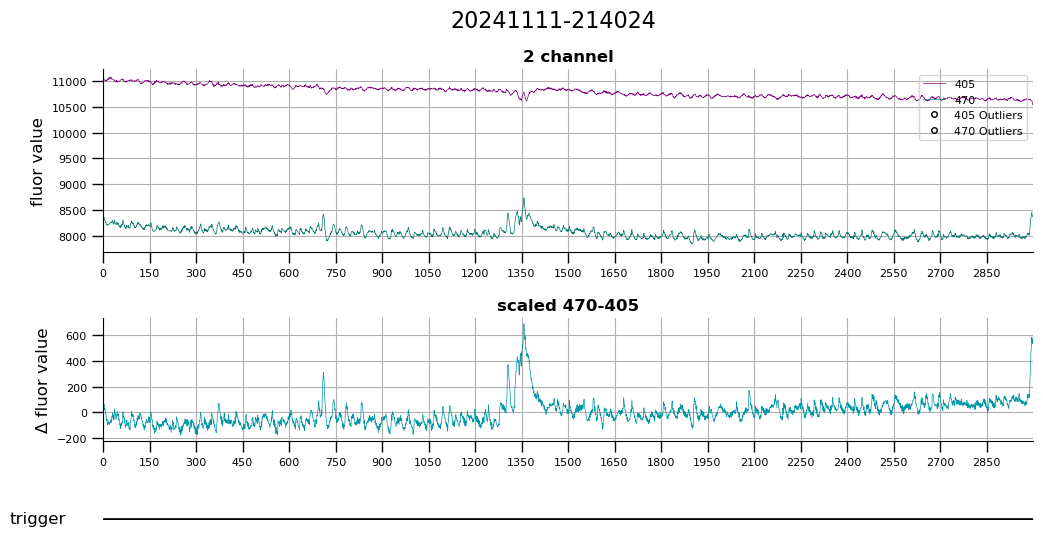


finished /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline


Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar
experiments:
['20241111-215129']


/home/lzx/.conda/envs/wfield/lib/python3.9/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20241111-215129-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


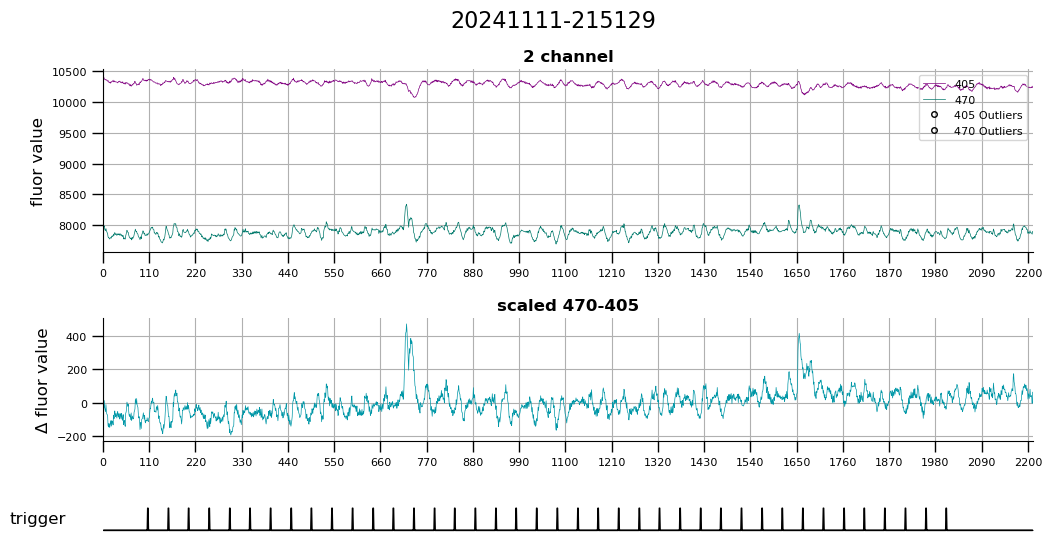


finished /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar


Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie
experiments:
['20241111-215658']


/home/lzx/.conda/envs/wfield/lib/python3.9/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20241111-215658-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


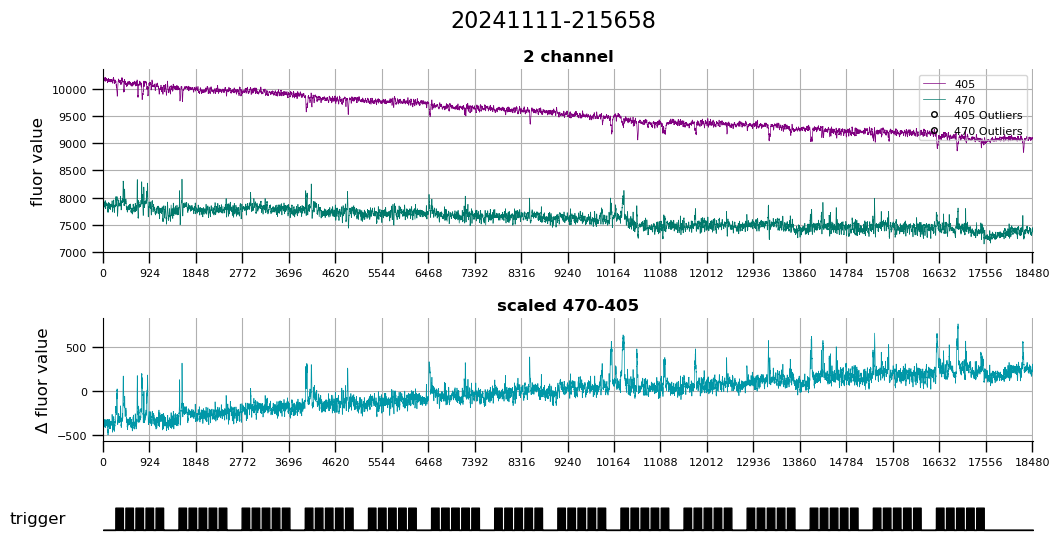


finished /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie


Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-invert
experiments:
['20241111-223236']


/home/lzx/.conda/envs/wfield/lib/python3.9/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20241111-223236-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


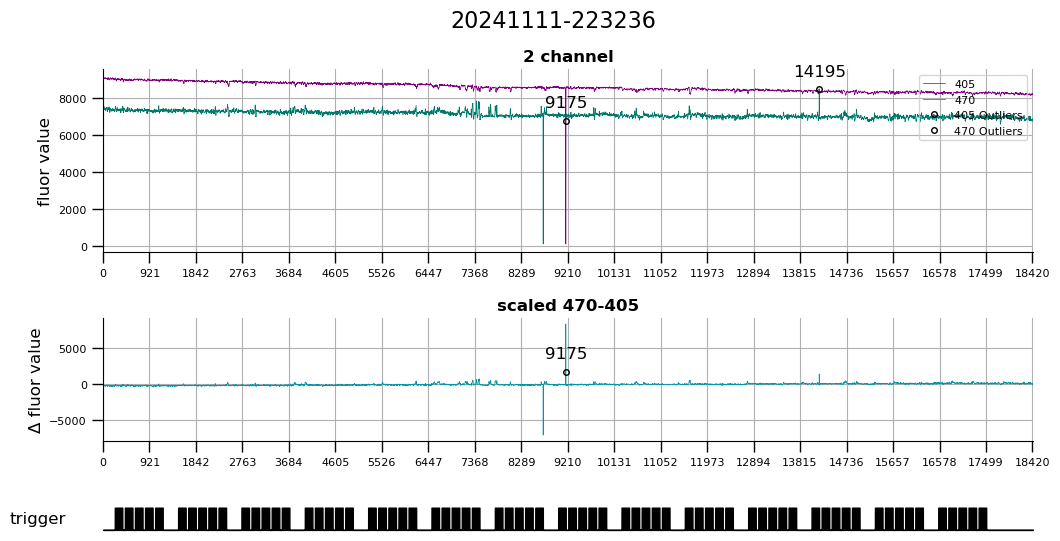


finished /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-invert


Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-reverse
experiments:
['20241111-230416']


/home/lzx/.conda/envs/wfield/lib/python3.9/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20241111-230416-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


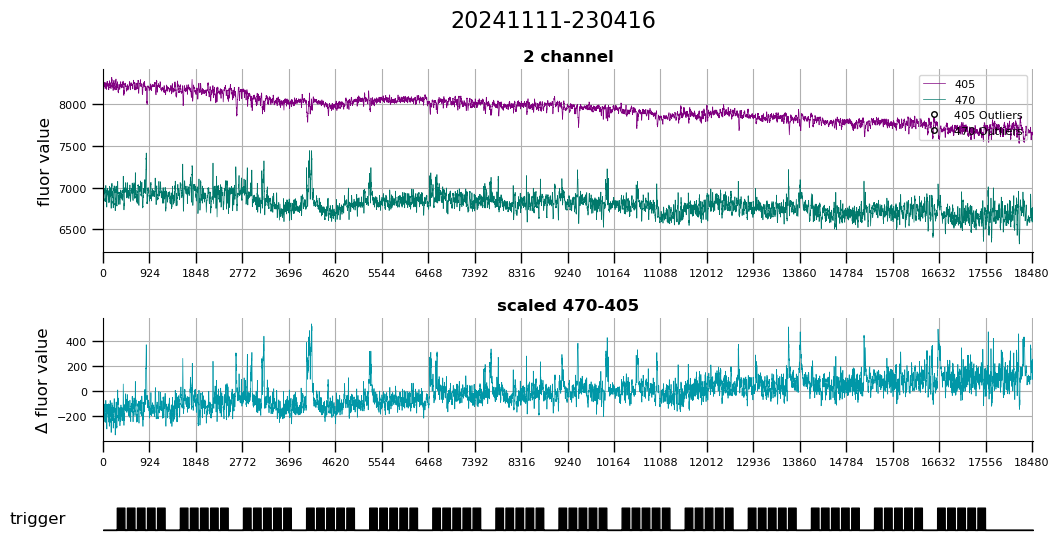


finished /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-reverse


Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/no-light
experiments:
['20241111-210230']


/home/lzx/.conda/envs/wfield/lib/python3.9/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20241111-210230-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


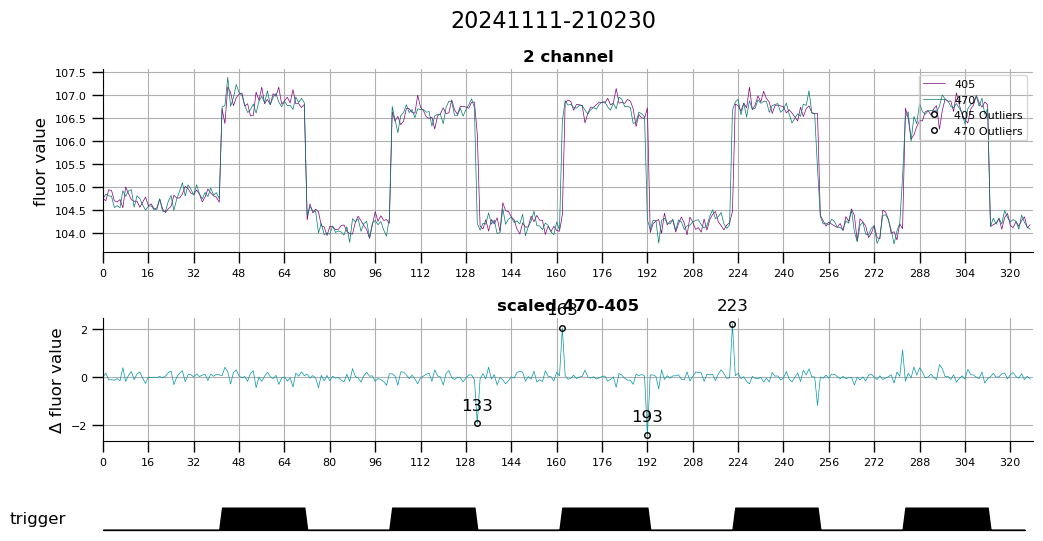


finished /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/no-light


Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/retinotopy
experiments:
['20241111-212438']


/home/lzx/.conda/envs/wfield/lib/python3.9/site-packages/tifffile/tifffile.py:1569: UserWarning: <tifffile.TiffWriter '20241111-212438-merged.tif'> writing nonconformant BigTIFF ImageJ
  warnings.warn(


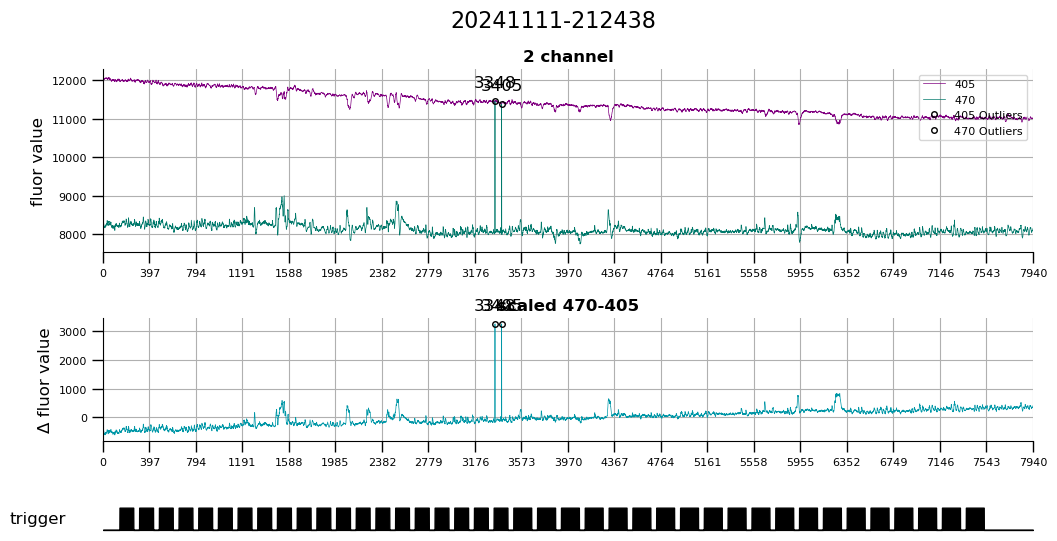


finished /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/retinotopy


All merging finished!


In [4]:
### generate 2-channel tif stack

def organize_tif(folder_path):
    folder_name = os.path.basename(folder_path)
    if os.path.exists(folder_path+'.tif'):
        print('importing {}.tif'.format(folder_path))
        image_stack = imread(folder_path+'.tif')
        print('finish importing {}.tif'.format(folder_path))
    else:
        image_path_ls = glob(pjoin(folder_path, '*.tif'))
        image_path_ls = sorted(image_path_ls, key = filename2int) # 确保图像帧按顺序排列
        image_stack = [imread(tiff) for tiff in log_progress(image_path_ls, name=folder_name)]  # 将多帧tif堆叠成数组
        # image_stack = multi_load_images(image_path_ls, n_thread=20)
    # rotated_images = [cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE) for frame in image_stack]   # 顺时针旋转图像90度
    # 计算并保存均值数据
    mean_values = [np.mean(frame) for frame in image_stack]
    output_value = pjoin(processPath, folder_name + "-Values.csv")
    np.savetxt(output_value, mean_values, delimiter=",")
    
    return np.array(image_stack)


for path in path_all:
    print("Path: "+ path)
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    # 列出experiments
    items = glob(pjoin(rawPath, '202?????-??????-4*'))
    experiments = list(set([os.path.basename(item)[:15] for item in items]))
    print("experiments:")
    print(experiments)
    
    # 遍历每个experiment，merge channel
    for experiment in experiments:
        os.makedirs(pjoin(processPath, experiment+"-wfield"), exist_ok=True)
        mergePath = pjoin(processPath, experiment+"-wfield")
        merge_file = pjoin(mergePath, experiment+"-merged.tif")
        if not os.path.exists(merge_file):
            tif_405 = organize_tif(pjoin(rawPath, experiment + "-405"))
            tif_470 = organize_tif(pjoin(rawPath, experiment + "-470"))
            # 检查两个通道的深度是否一致
            if tif_405.shape[0] != tif_470.shape[0]:
                n_frames = min(tif_405.shape[0], tif_470.shape[0])
                tif_405 = tif_405[:n_frames]
                tif_470 = tif_470[:n_frames]
            # 将Tiff stack的数据从三维变成四维，不同通道使用第二维区分
            merged_tif = np.concatenate((tif_470[:, np.newaxis], tif_405[:, np.newaxis]), axis=1)
            # 将合并后的图像保存为一个2通道Tiff图像
            imwrite(merge_file, merged_tif, imagej=True, bigtiff=True)
                        
        else: print("merged "+experiment+" has existed")
        plotFluor(path, experiment)
        
    print("\nfinished "+ path+"\n\n")
    
print("All merging finished!")


In [17]:
# 列出所有已经合并通道的tiff的路径

path_wfield_all = glob(pjoin(path_0, '*/process/*-wfield'))
print('All the wfield-path:\n'+"\n".join(path_wfield_all))


All the wfield-path:
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline/process/20241111-214024-wfield
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar/process/20241111-215129-wfield
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie/process/20241111-215658-wfield
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-invert/process/20241111-223236-wfield
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-reverse/process/20241111-230416-wfield
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/no-light/process/20241111-210230-wfield
/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/retinotopy/process/20241111-212438-wfield


In [6]:
# Create binary file
# Note: only one tif in the folder, and should no .bin file in the folder before running this cell
for path in path_wfield_all:
    print('\n\n'+path)
    _ls = os.listdir(path)
    if np.array([_.endswith('.bin') for _ in _ls]).any():
        print('!!! There are .bin files in the folder, please delete them before running!')
        continue
    if np.array([_.endswith('.tif') for _ in _ls]).sum() > 1:
        print('!!! There are more than one tif files in the folder, please check the folder!')
        continue
    tif_stack = TiffStack(glob(pjoin(path,'*-merged.tif')), nchannels=2) # set nchannels=1 for our 2 channel tif file
    print('The frames of the stack:', tif_stack.shape[0])
    if tif_stack.shape[0] == 0:
        print('The shape of the stack may be wrong!')
        continue
    else: 
        tif_stack.export_binary(foldername=path, basename='{}'.format(tif_stack.shape[0]))

print('finish generate binary file.')



/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline/process/20241111-214024-wfield


Parsing tiffs: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]

The frames of the stack: 3000



Exporting binary:   0%|          | 0/6 [00:00<?, ?it/s]

Loading 0


Exporting binary: 100%|██████████| 6/6 [00:34<00:00,  5.76s/it]




/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar/process/20241111-215129-wfield


Parsing tiffs: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s]

The frames of the stack: 2212



Exporting binary:   0%|          | 0/5 [00:00<?, ?it/s]

Loading 0


Exporting binary: 100%|██████████| 5/5 [00:17<00:00,  3.55s/it]




/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie/process/20241111-215658-wfield


Parsing tiffs: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

The frames of the stack:

 18497


Exporting binary:   0%|          | 0/37 [00:00<?, ?it/s]

Loading 0


Exporting binary: 100%|██████████| 37/37 [03:12<00:00,  5.21s/it]  




/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-invert/process/20241111-223236-wfield


Parsing tiffs: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

The frames of the stack: 18430



Exporting binary:   0%|          | 0/36 [00:00<?, ?it/s]

Loading 0


Exporting binary: 100%|██████████| 36/36 [03:15<00:00,  5.43s/it]  




/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-reverse/process/20241111-230416-wfield


Parsing tiffs: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


The frames of the stack: 18499


Exporting binary:   0%|          | 0/37 [00:00<?, ?it/s]

Loading 0


Exporting binary: 100%|██████████| 37/37 [02:37<00:00,  4.25s/it]  




/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/no-light/process/20241111-210230-wfield


Parsing tiffs: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


The frames of the stack: 328


Exporting binary:   0%|          | 0/1 [00:00<?, ?it/s]

Loading 0


Exporting binary: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]




/home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/retinotopy/process/20241111-212438-wfield


Parsing tiffs: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]

The frames of the stack: 7941



Exporting binary:   0%|          | 0/16 [00:00<?, ?it/s]

Loading 0


Exporting binary: 100%|██████████| 16/16 [00:41<00:00,  2.62s/it]


finish generate binary file.


### Check and correct outliers

In [7]:
def detect_lum_outlier(mean_values, lum_thr_coef=0.3, plot=True):
    '''
    Detect outliers in the mean_values array.
    Parameters:
        mean_values: numpy array, the mean values of the image stack. 
        The first column is the mean values of 470 channel, the second column is the mean values of 405 channel.
        lum_thr_coef: luminance threshold coefficient for detecting luminance outliers.
    Returns:
        outlier_index: numpy array, the index of the outliers, 
        each row contains the start and end index of the outliers,
        the value of mean_values[start:end] is considered as outliers.
    '''
    # detecting luminance outliers
    outlier_lum_470 = mean_values[:, 0] < np.mean(mean_values[:, 0])*lum_thr_coef
    outlier_lum_idx_470 = np.where(outlier_lum_470)[0]
    if len(outlier_lum_idx_470) > 0:
        # Frames before and after the detected outliers are also considered as outliers,
        # Output index is the start and end index of the outliers,
        # Note the frame of the end index is normal, so add 2 to the end index.
        outlier_lum_idx_470 = np.array((outlier_lum_idx_470[0]-1, outlier_lum_idx_470[-1]+2))

    outlier_lum_405 = mean_values[:, 1] < np.mean(mean_values[:, 1])*lum_thr_coef
    outlier_lum_idx_405 = np.where(outlier_lum_405)[0]
    if len(outlier_lum_idx_405) > 0:
        outlier_lum_idx_405 = np.array((outlier_lum_idx_405[0]-1, outlier_lum_idx_405[-1]+2))

    outlier_index = [outlier_lum_idx_470, outlier_lum_idx_405]

    if plot:
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(mean_values[:, 0], label='470', color='g')
        ax.plot(mean_values[:, 1], label='405', color='purple')
        ax.set_xlim(0, len(mean_values))
        # for idx in outlier_index[0]:
        #     ax.axvline(x=idx, color='r', linestyle='--')
        # for idx in outlier_index[1]:
        #     ax.axvline(x=idx, color='r', linestyle='--')
        if len(outlier_lum_idx_470) > 0:
            ax.hlines(np.mean(mean_values[:, 0])*lum_thr_coef, 0, len(mean_values), color='g', linestyle='--')
        if len(outlier_lum_idx_405) > 0:
            ax.hlines(np.mean(mean_values[:, 1])*lum_thr_coef, 0, len(mean_values), color='purple', linestyle='--')
        ax.legend()
        plt.title('raw mean values')
        plt.show()
    
    if len(outlier_lum_idx_470) > 0 or len(outlier_lum_idx_405) > 0:
        print('\33[91mluminance outliers detected!\33[0m')
        print('luminance outlier index:\n')
        print(outlier_index)
    else:
        print('No luminance outliers detected')

    return outlier_index



def correct_lum_outlier(bin_path, outlier_index_470, outlier_index_405, overwrite=True, plot=True):
    '''
    Correct the luminance outliers frames in the merged tiff file.
    '''
    if (outlier_index_470 is not None) or (outlier_index_405 is not None):
        print('luminance outliers frames need to be corrected!')
        bin_name = os.path.splitext(os.path.basename(bin_path))[0]
        dtype = bin_name.split('_')[-1]
        shape = tuple([int(i) for i in bin_name.split('_')[:-1]])
        images = np.memmap(bin_path, dtype=dtype, mode='r+', shape=shape)
        if outlier_index_470 is not None:
            for i_outlier in outlier_index_470:
                start, end = i_outlier
                images[start:end+1, 0, :, :] = 0.5*images[start-1, 0, :, :] + 0.5*images[end+1, 0, :, :]
        if outlier_index_405 is not None:
            for i_outlier in outlier_index_405:
                start, end = i_outlier
                images[start:end+1, 1, :, :] = 0.5*images[start-1, 1, :, :] + 0.5*images[end+1, 1, :, :]
        if overwrite:
            images.flush()
            print('Luminance outliers frames corrected!')
       
    else:
        print('No luminance outliers frames to correct')


    mean_values_470 = images[:, 0, :, :].mean(axis=(1,2))
    mean_values_405 = images[:, 1, :, :].mean(axis=(1,2))
    mean_values_corrected = np.concatenate((mean_values_470[:, np.newaxis], mean_values_405[:, np.newaxis]), axis=1)    
    if plot:
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(mean_values_470, label='470', color='g')
        ax.plot(mean_values_405, label='405', color='purple')
        ax.set_xlim(0, len(mean_values_470))
        ax.legend()
        plt.title('correct_luminance_outlier')
        plt.show()

    return mean_values_corrected



def detect_cross_outlier(time_stamp_470, time_stamp_405, time_thr=10):
    '''
    detect the cross-channel outliers based on the time stamps of 405 and 470 channels
    cross-channel: the 405 or 470 channel frames wrongly recoreded.
    time_thr: the threshold of the vairance of the interval between the 405 and 470 channels
    '''
    diff_time = abs(time_stamp_470 - time_stamp_405)
    time_outliers_idx_advance = np.where(diff_time < (50-time_thr))[0]
    time_outliers_idx_lag = np.where(diff_time > (50+time_thr))[0] + 1

    if time_stamp_470[0] < time_stamp_405[0]: # 470 channel starts first
        return time_outliers_idx_lag, time_outliers_idx_advance
    else: # 405 channel starts first
        return time_outliers_idx_advance, time_outliers_idx_lag



def correct_cross_outlier(bin_path, outlier_index_470, outlier_index_405, overwrite=True, plot=True):
    '''
    Correct the outliers frames in the merged tiff file.
    Parameters:
        bin_path: string, the path of the bin file.
        outlier_index_405: numpy array, the index of the outliers in 405 channel.
        outlier_index_470: numpy array, the index of the outliers in 470 channel.
    '''

    if (len(outlier_index_470) > 0) or (len(outlier_index_405) > 0):
        print('cross-channel outliers frames need to be corrected!')
        bin_name = os.path.splitext(os.path.basename(bin_path))[0]
        dtype = bin_name.split('_')[-1]
        shape = tuple([int(i) for i in bin_name.split('_')[:-1]])
        images = np.memmap(bin_path, dtype=dtype, mode='r+', shape=shape)
        if len(outlier_index_470) > 0:
            for i in outlier_index_470:
                print(f'correct 470channel {i}th frame')
                images[i, 0, :, :] = 0.5*images[i-1, 0, :, :] + 0.5*images[i+1, 0, :, :]
        if len(outlier_index_405) > 0:
            for i in outlier_index_405:
                print(f'correct 405channel {i}th frame')
                images[i, 0, :, :] = 0.5*images[i-1, 0, :, :] + 0.5*images[i+1, 0, :, :] # in this case, 470 channel also need to be corrected
                # images[i, 0, :, :] = 0
                images[i, 1, :, :] = 0.5*images[i-1, 1, :, :] + 0.5*images[i+1, 1, :, :]
        if overwrite:
            images.flush() # save the changes
            print('cross-channel outliers frames corrected!')

    else:
        print('No cross-channel outliers frames to correct')

    
    mean_values_470 = images[:, 0, :, :].mean(axis=(1,2))
    mean_values_405 = images[:, 1, :, :].mean(axis=(1,2))
    mean_values_corrected = np.concatenate((mean_values_470[:, np.newaxis], mean_values_405[:, np.newaxis]), axis=1)
    if plot:
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(mean_values_470, label='470', color='g')
        ax.plot(mean_values_405, label='405', color='purple')
        ax.set_xlim(0, len(mean_values_470))
        ax.legend()
        plt.title('correct_cross-channel_outlier')
        plt.show()


    return mean_values_corrected



#########################################################################################################################
def detect_outlier(mean_values, std_thr=5, plot=True):
    '''
    Detect outliers in the mean_values array.
    Parameters:
        mean_values: numpy array, the mean values of the image stack. 
        The first column is the mean values of 470 channel, the second column is the mean values of 405 channel.
        std_thr: luminance threshold coefficient for detecting luminance outliers.
    Returns:
        outlier_index: list, where each element is a tuple representing a segment of outlier indices.
        Each tuple contains the start and end index of a continuous outlier segment.
    '''
    def find_continuous_outliers(outlier_lum_idx):
        """
        Helper function to find continuous segments of outliers.
        If the segment length is greater than 3, adjust start and end positions.
        """
        if len(outlier_lum_idx) == 0:
            return []

        segments = []
        start = outlier_lum_idx[0]
        
        # Iterate through outlier indices and group continuous outliers
        for i in range(1, len(outlier_lum_idx)):
            if outlier_lum_idx[i] != outlier_lum_idx[i-1] + 1:
                segments.append((start, outlier_lum_idx[i-1]))  # End the previous segment
                start = outlier_lum_idx[i]  # Start a new segment

        # Append the last segment
        segments.append((start, outlier_lum_idx[-1]))

        # Adjust the start and end positions for segments with length > 3
        adjusted_segments = []
        for segment in segments:
            start, end = segment
            if end - start + 1 > 3:  # If the segment length is greater than 3
                # Adjust start and end positions
                adjusted_start = max(start - 1, 0)  # Prevent going below 0
                adjusted_end = min(end + 1, len(mean_values) - 1)  # Prevent going above the length of the data
                adjusted_segments.append((adjusted_start, adjusted_end))
            else:
                adjusted_segments.append(segment)

        return adjusted_segments
    
    # Detecting outliers for 470 channel
    outlier_lum_470 = mean_values[:, 0] < mean_values[:, 0].mean() - std_thr * mean_values[:, 0].std()
    outlier_lum_idx_470 = np.where(outlier_lum_470)[0]
    outlier_lum_idx_470_segments = find_continuous_outliers(outlier_lum_idx_470)

    # Detecting outliers for 405 channel
    outlier_lum_405 = (mean_values[:, 1] < mean_values[:, 1].mean() - std_thr * mean_values[:, 1].std()) | (
        mean_values[:, 1] > mean_values[:, 1].mean() + std_thr * mean_values[:, 1].std())
    outlier_lum_idx_405 = np.where(outlier_lum_405)[0]
    outlier_lum_idx_405_segments = find_continuous_outliers(outlier_lum_idx_405)

    # Combine both segments
    outlier_index = [outlier_lum_idx_470_segments, outlier_lum_idx_405_segments]

    # Plot if requested
    if plot:
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(mean_values[:, 0], label='470', color='g')
        ax.plot(mean_values[:, 1], label='405', color='purple')
        ax.set_xlim(0, len(mean_values))

        # Plot outlier points and annotate them
        for segment in outlier_lum_idx_470_segments:
            start, end = segment
            ax.plot(np.arange(start, end+1), mean_values[start:end+1, 0], 'ko', fillstyle='none', markerfacecolor='none')
            ax.annotate(f'{start+1:.0f}', (start, mean_values[start, 0]), textcoords="offset points", xytext=(0, 10), ha='center')

        for segment in outlier_lum_idx_405_segments:
            start, end = segment
            ax.plot(np.arange(start, end+1), mean_values[start:end+1, 1], 'ro', fillstyle='none', markerfacecolor='none')
            ax.annotate(f'{start+1:.0f}', (start, mean_values[start, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

        ax.legend()
        plt.title('Raw Mean Values with Outliers')
        plt.show()
    
    if len(outlier_lum_idx_470_segments) > 0 or len(outlier_lum_idx_405_segments) > 0:
        print('\33[91moutliers detected!\33[0m')
        print('Outlier index:\n')
        print(outlier_index)
    else:
        print('No outliers detected')

    return outlier_index



In [24]:
overwrite = True




Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline
experiment: 20241111-214024
bin_path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline/process/20241111-214024-wfield/3000_2_512_512_uint16.bin


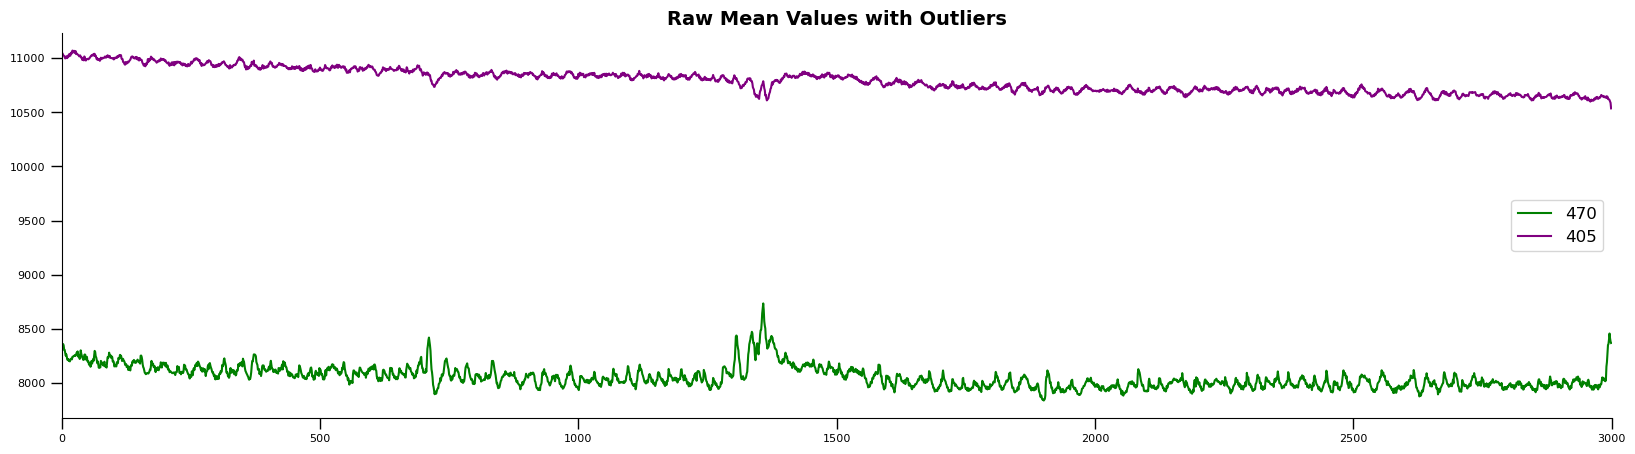

No outliers detected



Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar
experiment: 20241111-215129
bin_path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar/process/20241111-215129-wfield/2212_2_512_512_uint16.bin


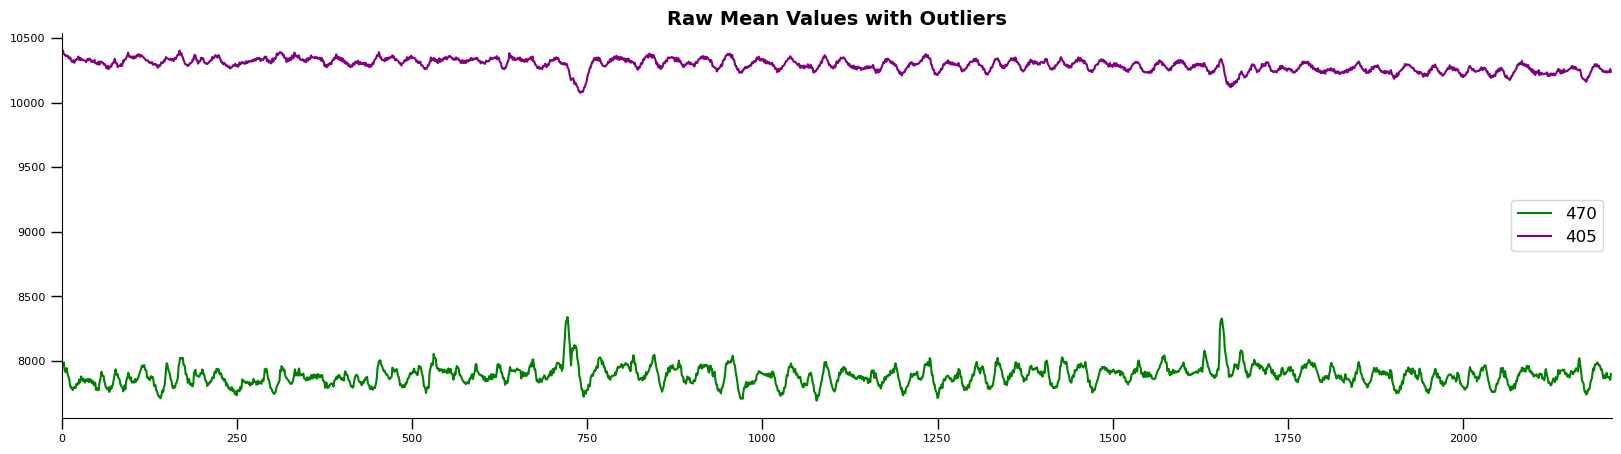

No outliers detected



Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie
experiment: 20241111-215658
bin_path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie/process/20241111-215658-wfield/18497_2_512_512_uint16.bin


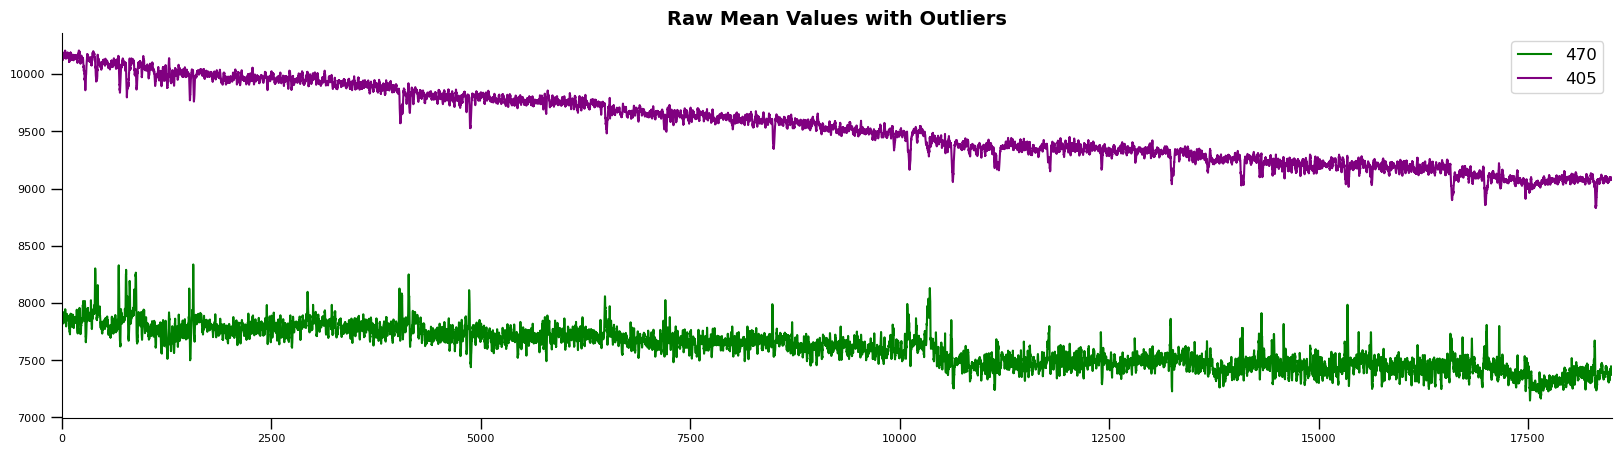

No outliers detected



Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-invert
experiment: 20241111-223236
bin_path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-invert/process/20241111-223236-wfield/18430_2_512_512_uint16.bin


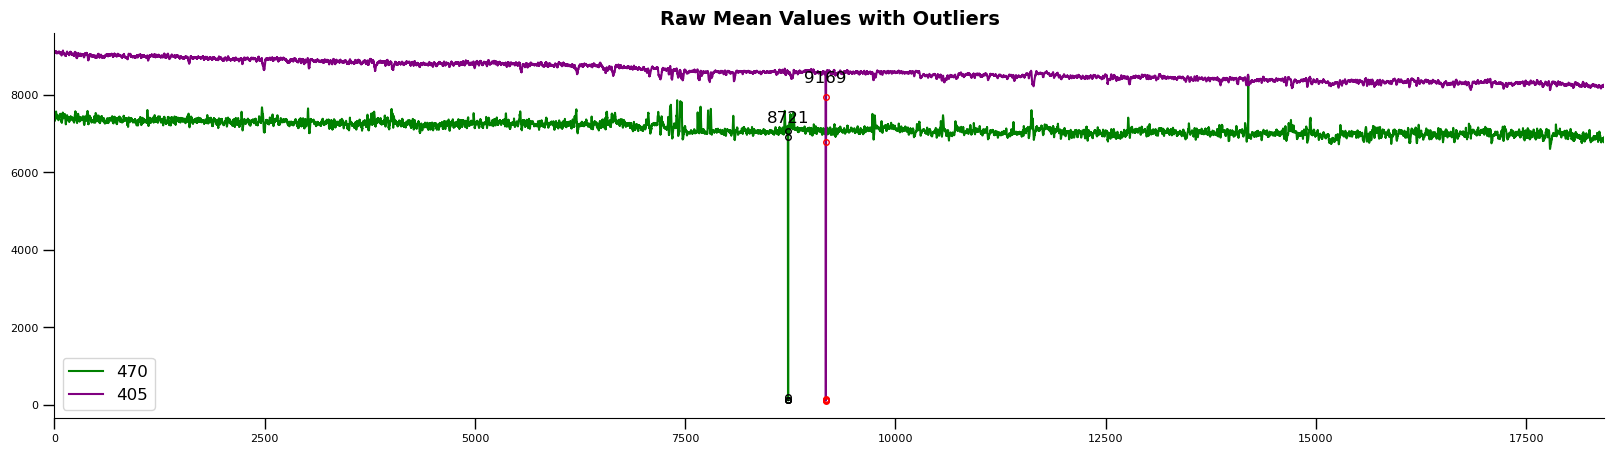

outliers detected!
Outlier index:

[[(8720, 8726)], [(9168, 9174)]]
luminance outliers frames need to be corrected!
Luminance outliers frames corrected!


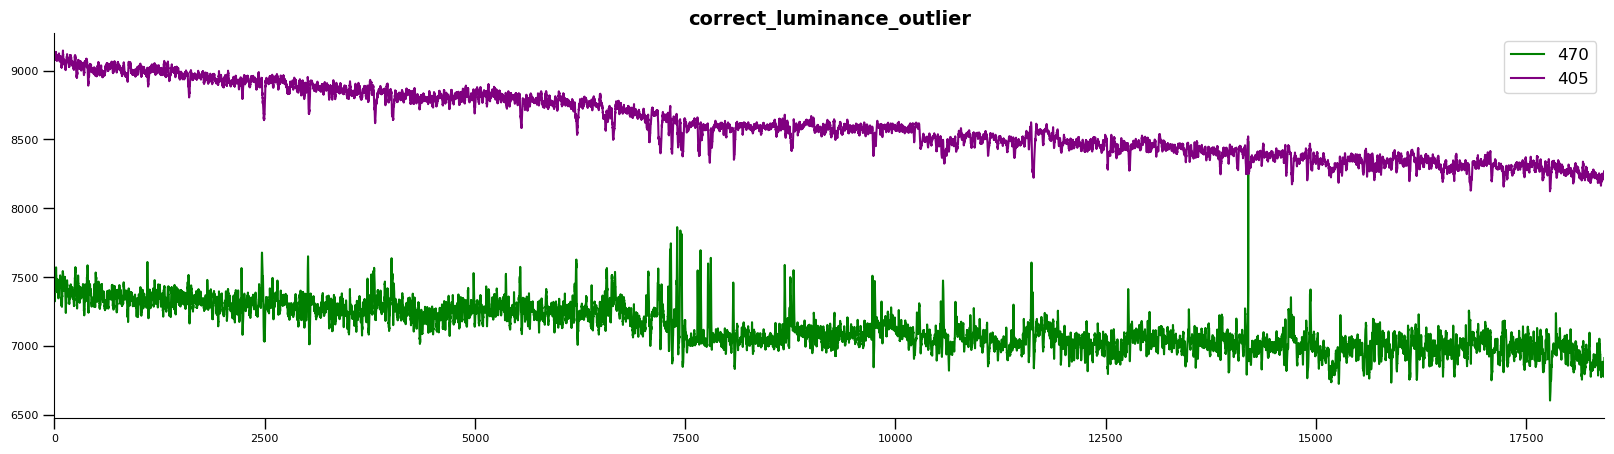




Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-reverse
experiment: 20241111-230416
bin_path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-reverse/process/20241111-230416-wfield/18499_2_512_512_uint16.bin


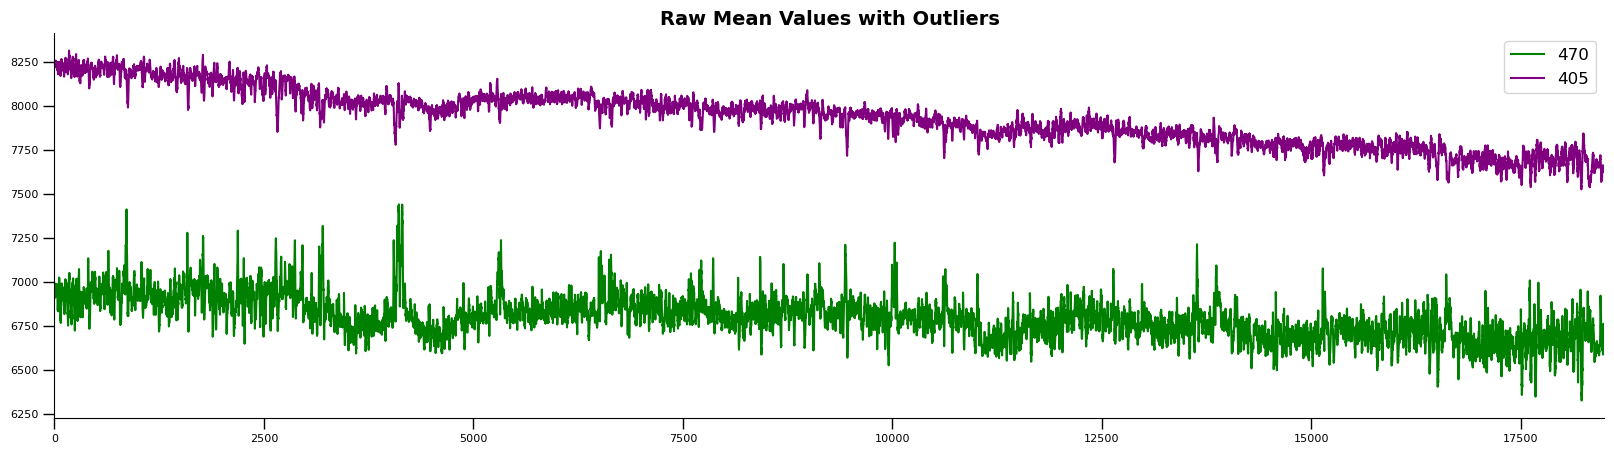

No outliers detected



Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/no-light
experiment: 20241111-210230
bin_path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/no-light/process/20241111-210230-wfield/328_2_512_512_uint16.bin


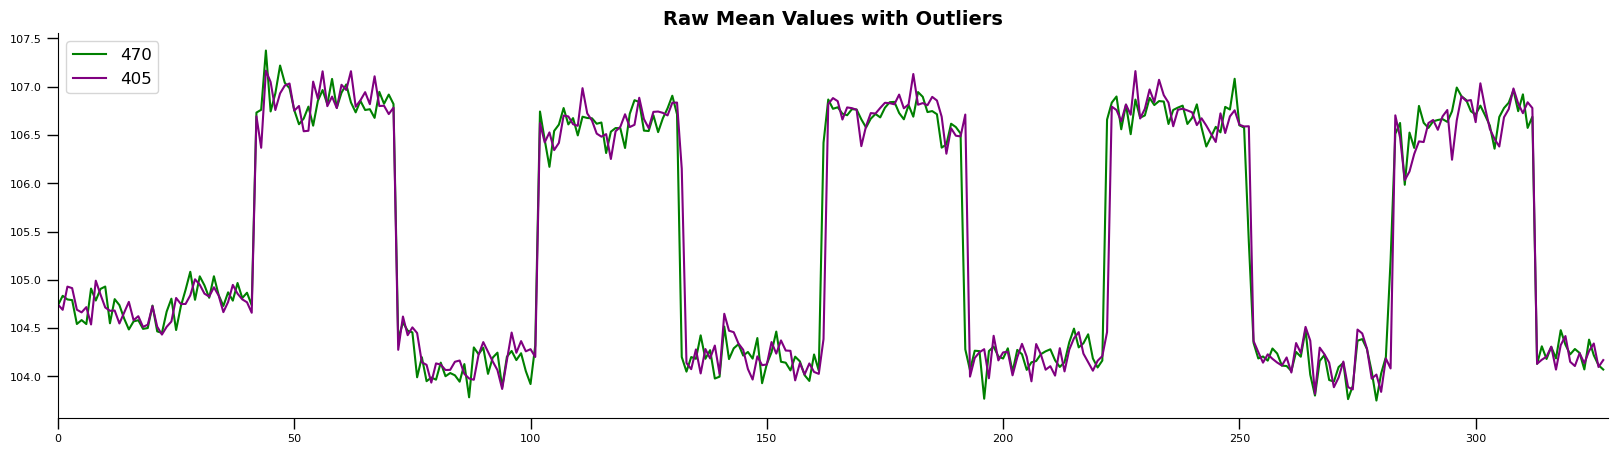

No outliers detected



Path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/retinotopy
experiment: 20241111-212438
bin_path: /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/retinotopy/process/20241111-212438-wfield/7941_2_512_512_uint16.bin


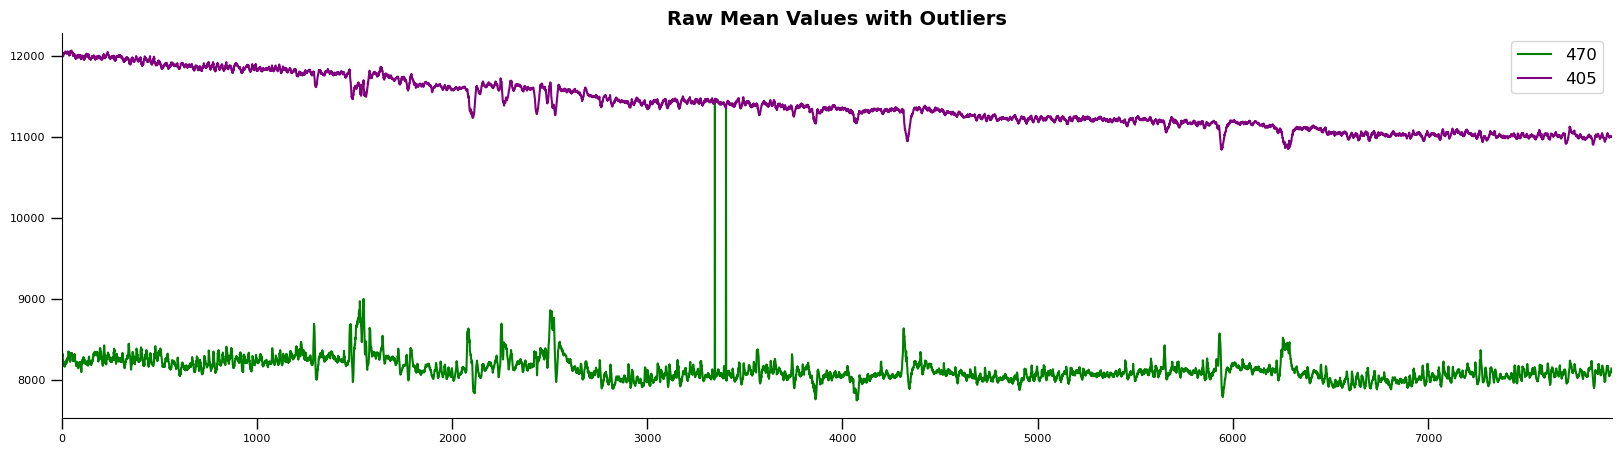

No outliers detected


In [25]:
# detect outliers based on the mean values of 405 and 470 channels,
# and correct the outliers by averaging the values of the previous and next frames


for path in path_all:
    stim_name = os.path.split(path)[-1]
    rawPath = pjoin(path, "raw")
    processPath = pjoin(path, "process")
    
    items = glob(pjoin(rawPath, '202?????-??????-4*'))
    experiments = list(set([os.path.basename(item)[:15] for item in items]))

    for experiment in experiments:
        print("\n\n\nPath: "+ path)
        print("experiment:", experiment)
        bin_path = glob(pjoin(processPath, experiment+"-wfield", '*uint16.bin'))[0]
        print(f'bin_path: {bin_path}')
        
        values_405_path = pjoin(path, "process", f'{experiment}-405-Values.csv')
        values_470_path = pjoin(path, "process", f'{experiment}-470-Values.csv')
        mean_values_405 = np.loadtxt(values_405_path, delimiter=',')
        mean_values_470 = np.loadtxt(values_470_path, delimiter=',')
        n_frames = min(mean_values_405.shape[0], mean_values_470.shape[0])
        mean_values_405 = mean_values_405[:n_frames]
        mean_values_470 = mean_values_470[:n_frames]
        mean_values = np.concatenate((np.expand_dims(mean_values_470, axis=1), np.expand_dims(mean_values_405, axis=1)), axis=1)
        
        outlier_index_470, outlier_index_405 = detect_outlier(mean_values, std_thr=7, plot=True)
        if len(outlier_index_470) > 0 or len(outlier_index_405) > 0:
            mean_values_corrected = correct_lum_outlier(bin_path, outlier_index_470, outlier_index_405, plot=True, overwrite=overwrite)
            np.savetxt(pjoin(path, "process", f'{experiment}-corrected values.csv'), mean_values_corrected, delimiter=",")
        


    
        ## deal with luminance error:
        # outlier_index_470, outlier_index_405 = detect_lum_outlier(mean_values, lum_thr_coef=0.4, plot=True)
        # if len(outlier_index_470) > 0 or len(outlier_index_405) > 0:
        #     mean_values_corrected = correct_lum_outlier(bin_path, outlier_index_470, outlier_index_405, plot=True, overwrite=False)
        #     np.savetxt(pjoin(path, "process", f'{experiment}-corrected values.csv'), mean_values_corrected, delimiter=",")


        # # deal with cross-channel error:
        # time_stamp_405 = np.loadtxt(glob(pjoin(path, "raw", f'{experiment}-405Timestamp.csv'))[0], delimiter=',')
        # time_stamp_470 = np.loadtxt(glob(pjoin(path, "raw", f'{experiment}-470Timestamp.csv'))[0], delimiter=',')

        # if not len(time_stamp_405) == len(time_stamp_470):
        #     print("The length difference between 405 and 470 timestamps: ", len(time_stamp_405) - len(time_stamp_470))
        #     _len = min(len(time_stamp_405), len(time_stamp_470))
        #     time_stamp_405 = time_stamp_405[:_len]
        #     time_stamp_470 = time_stamp_470[:_len]

        # outlier_index = detect_cross_outlier(time_stamp_470, time_stamp_405, time_thr=10)
        # if outlier_index[0].size == 0 and outlier_index[1].size == 0:
        #     print('No cross-channel error')
        # else:
        #     print('\33[91mcross-channel error detected!\33[0m')
        #     mean_values_corrected = correct_cross_outlier(bin_path, outlier_index_470=outlier_index[0], outlier_index_405=outlier_index[1], overwrite=False)
        #     np.savetxt(pjoin(path, "process", f'{experiment}-corrected values.csv'), mean_values_corrected, delimiter=",")





### ********************************************************************************************************************
### 从这里开始用wfield软件做运动矫正、奇异值分解、血流动力学矫正。以下必须用wfield环境！！！
### ********************************************************************************************************************

In [10]:
# try wfield

! wfield -h

usage: wfield <command> [<args>]

The commands are:
    ncaas               Opens a gui to launch data on the neuroCAAS platform
    open                Opens a gui to look at the preprocessed data        
    open_raw            Opens a gui to look at the raw frames
    preprocess          Preprocess data in binary fornat
    motion              Registers data from a binary file
    decompose           Performs single value decomposition
    correct             Performs hemodynamic correction on dual channel data
    imager              
    imager_preprocess   Preprocesses data recorded with the WidefieldImager

wfield - tools to process widefield data

positional arguments:
  command     type wfieldtools <command> -h for help

optional arguments:
  -h, --help  show this help message and exit


In [11]:
path_delete = glob(pjoin(path_0, '*/process/*-wfield/motioncorrect*'))
path_delete


[]

In [12]:
for file_delete in path_delete:
    try:
        os.remove(file_delete)
        print(f"Deleted: {file_delete}")
    except Exception as e:
        print(f"Error deleting {file_delete}: {e}")

In [13]:
### 生成trial_onsets.npy

n_movie_rep = 5

for path_wfield in path_wfield_all:
    
    experiment = os.path.basename(path_wfield)[:15]
    rawPath = pjoin(path_wfield,'../../raw')
    merge_file = pjoin(path_wfield, experiment+"-merged.tif")
    n_frames = len(TiffFile(merge_file).pages)//2

    if os.path.exists(pjoin(rawPath, experiment + ".csv")):
        # generate trial_onsets.npy
        # trial_onsets.npy is a Nx3 array. The columns are: trial number, onset of the trial (frame index), offset of the trial.
        if not os.path.exists(pjoin(path_wfield, 'trials.csv')):
            stimfile = pd.read_csv(pjoin(rawPath, experiment + ".csv"), header=None).values
            stim_delay = pd.read_csv(pjoin(rawPath, experiment + "-470Timestamp.csv"), header=None).values
            stim_delay = int(stim_delay[0]/100)
            n_stimframe = min(stimfile.shape[0]//100-1, n_frames)
            stim = np.zeros(n_stimframe)
            for i in range(n_stimframe):
                stim[i] = stimfile[(i * 100 + stim_delay), 0]
            single_0_indices = np.where((np.diff(np.append(stim, 0)) == 1) & (np.diff(stim, prepend=0) == -1))[0]
            single_1_indices = np.where((np.diff(np.append(stim, 0)) == -1) & (np.diff(stim, prepend=0) == 1))[0]
            stim[single_1_indices] = 0
            stim[single_0_indices] = 1
            
            onset = np.where(np.diff(stim) == 1)[0] + 1
            offset = np.where(np.diff(stim) == -1)[0] + 1
            n_trigger = min(len(onset),len(offset))
            onset = onset[:n_trigger]
            offset = offset[:n_trigger]                
            trials_csv = np.stack((np.arange(len(onset)), onset, offset, offset-onset), axis=1)  # 这个用来自己检查一下以及自己后续分析
            np.savetxt(pjoin(path_wfield, "trials.csv"), trials_csv, delimiter=",")
            print("generate trials.csv of "+experiment)
            
            if 'retinotopy' in path_wfield or 'checkerboard-bar' in path_wfield:
                trial_onsets = np.stack((np.arange(len(onset)), onset - 30, offset), axis=1)  # 这个文件给wfield软件做SVD用
                np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)
            
            elif 'natural-movie' in path_wfield:
                n_movie = len(onset)//n_movie_rep
                trial_onsets = np.empty((n_movie,3))
                for i in range(n_movie):
                    trial_onsets[i] = [i, onset[i*n_movie_rep] - 100, offset[i*n_movie_rep]]
                np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用
            # elif 'speed' in path_wfield:
            #     trial_onsets = [0, onset[0] - 100, offset[0]]
            #     np.save(pjoin(path_wfield, 'trial_onsets.npy'), trial_onsets)   # 这个文件给wfield软件做SVD用
        else: print("trials.csv of "+experiment+" has existed")

    else: print(experiment, 'without stim-file, skip')
            
print("\nAll generation of trials-file finished!")


generate trials.csv of 20241111-214024
generate trials.csv of 20241111-215129
generate trials.csv of 20241111-215658
generate trials.csv of 20241111-223236
generate trials.csv of 20241111-230416
generate trials.csv of 20241111-210230
generate trials.csv of 20241111-212438

All generation of trials-file finished!


In [14]:
# 用wfield进行Motion correction, single value decomposition, hemodynamic correction。

for path_wfield in path_wfield_all:
    if len(glob(pjoin(path_wfield, '*-merged.tif'))) == 0:
        print(path_wfield,"can't find merged tiff file!\n")
    elif len(glob(pjoin(path_wfield, '*-merged.tif'))) > 1:
        print(path_wfield,"exist multiple merged tiff file!\n")
    elif os.path.exists(pjoin(path_wfield, 'SVTcorr.npy')):
        print(path_wfield,'analysis has been finished!\n')
    else:
        print('Start analyze',path_wfield)
        if 'natural-movie' or 'speed' in path_wfield:
            nbaseline_frames = 100
        else: 
            nbaseline_frames = 30
        command = "wfield preprocess --nchannels 2 --nbaseline-frames {} --functional-channel 0 --fs 10 -o {} {}".format(nbaseline_frames,path_wfield,path_wfield)
        logfile = pjoin(path_wfield, 'log.txt')
        with open(logfile, "w") as log:
            result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
            log.write(result.stdout)
        if result.returncode == 0:
            print('Finish analyzing',path_wfield,'\n')
        else:
            print('！！！Error occured when analyzing',path_wfield,'\n')
        
print('\nMotion correction, single value decomposition, hemodynamic correction. All finished!')


Start analyze /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline/process/20241111-214024-wfield
Finish analyzing /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/baseline/process/20241111-214024-wfield 

Start analyze /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar/process/20241111-215129-wfield
Finish analyzing /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/moving-bar/process/20241111-215129-wfield 

Start analyze /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie/process/20241111-215658-wfield
Finish analyzing /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie/process/20241111-215658-wfield 

Start analyze /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-invert/process/20241111-223236-wfield
Finish analyzing /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-invert/process/20241111-223236-wfield 

Start analyze /home/lzx/data/WF_VC_liuzhaoxi/24.11.11_H78/natural-movie-reverse/process/20241111-230416-wfield
Finish analyzing /home/lzx/data/WF_VC_liuzhaoxi

In [15]:
# 重构矫正后图像

export_corr_tif = False

if export_corr_tif is True:
    for path_wfield in path_wfield_all:
        print('\npath', path_wfield)
        filename = os.path.basename(glob(pjoin(path_wfield, '*-merged.tif'))[0])[:16]
        if not (os.path.exists(pjoin(path_wfield, filename+"SVD_corr.tif")) or os.path.exists(pjoin(path_wfield, filename+"SVD_corr_uint16.tif")) or os.path.exists(pjoin(path_wfield, filename+"hemo-corr.tif"))):
            svd2tif(path_wfield, name=filename, uint16=False, corr470=True)
        else:
            print('reconstruction has been finished！')
        
    print('\n\nAll image reconstruction finished!')


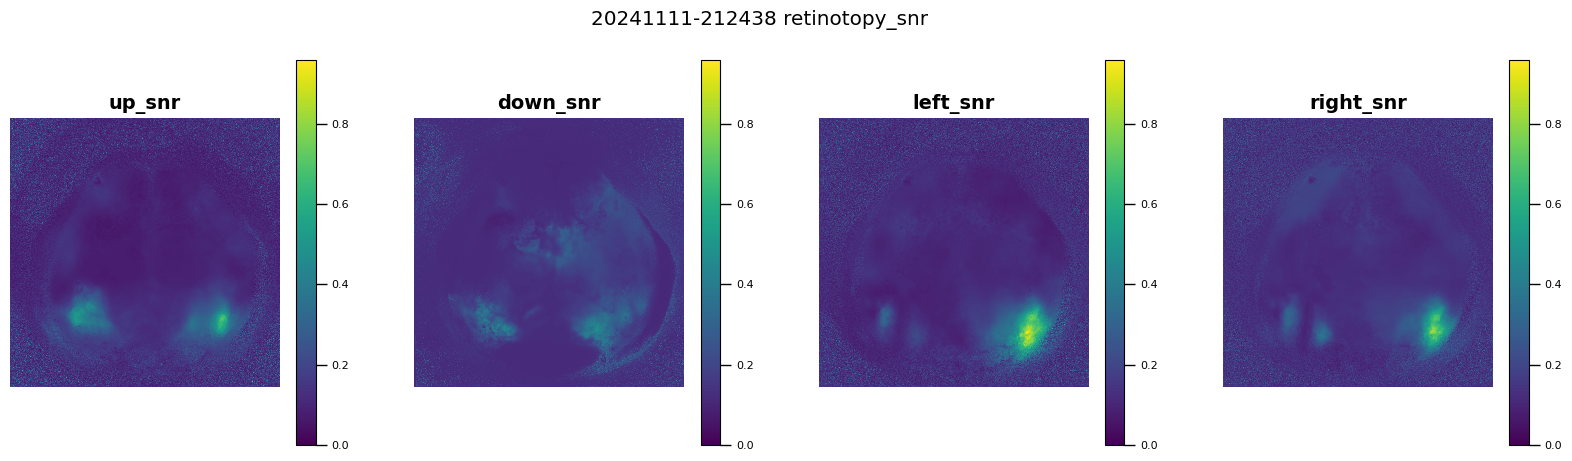

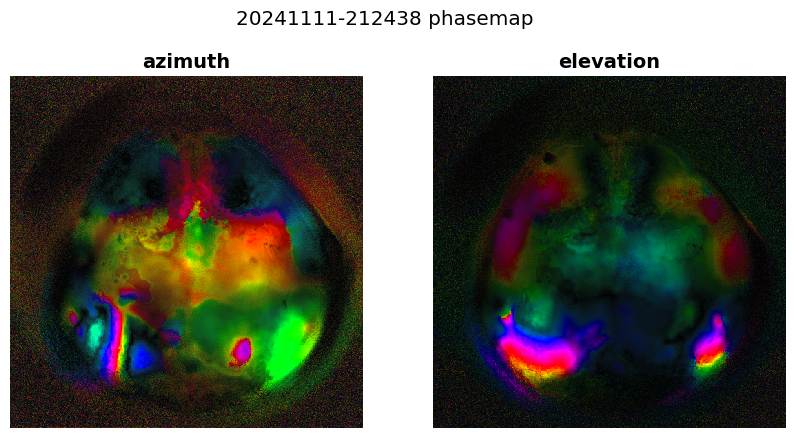

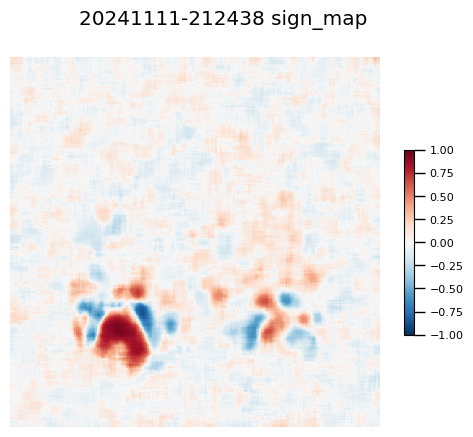

Finish exporting average tif
Finish exporting rep tif


In [16]:
from wfield_utils import *

for path_wfield in path_wfield_all:
    if 'retinotopy' in path_wfield or 'checkerboard-bar' in path_wfield:
        phasemap(path_wfield, nrepeats=10, post_trial=3, export_ave_tif=False, export_raw_tif=False, 
         plot_snr=True, plot_phasemasp=True, export_phase=True)
        phasemap(path_wfield, nrepeats=10, post_trial=0, export_ave_tif=True, export_raw_tif=True, 
         plot_snr=False, plot_phasemasp=False, export_phase=False)